In [3]:
import os, shutil

original_dataset_dir = '/Volumes/KESU/dog_vs_cat/train'
base_dir = '/Volumes/KESU/dog_vs_cat/dataset'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)


In [4]:
#trainデータの８割を学習用、残りをバリデーション用として使用する
#eaach images 12500 
#train images 10000
#validation images 2500

fnames_cat = ['cat.{}.jpg'.format(i) for i in range(12500)]
fnames_dog = ['dog.{}.jpg'.format(i) for i in range(12500)]

In [5]:
#重複を許さず、猫ファイル名を取得
import random

files_cat = fnames_cat

# 乱数により移動先を振り分け

for f in files_cat:
    if random.random() >= 0.2: 
        # 学習用フォルダへ移動
        src = os.path.join(original_dataset_dir, f)
        dst = os.path.join(train_cats_dir,f)
        shutil.copy(src,dst)
    else:                      
        # dir2へ移動
        src = os.path.join(original_dataset_dir,f)
        dst = os.path.join(validation_cats_dir,f)
        shutil.copy(src,dst)

In [6]:
#重複を許さず、犬ファイル名を取得

# 乱数により移動先を振り分け

for f in fnames_dog:
    if random.random() >= 0.2: 
        # 学習用フォルダへ移動
        src = os.path.join(original_dataset_dir, f)
        dst = os.path.join(train_dogs_dir,f)
        shutil.copy(src,dst)
    else:                      
        # dir2へ移動
        src = os.path.join(original_dataset_dir,f)
        dst = os.path.join(validation_dogs_dir,f)
        shutil.copy(src,dst)

In [7]:
print('total training cat images', len(os.listdir(train_cats_dir)))
print('total training dog images', len(os.listdir(train_dogs_dir)))
print('///////////////////////////////////////////////////')
print('total validation cat images', len(os.listdir(validation_cats_dir)))
print('total validation dog images', len(os.listdir(validation_dogs_dir)))

total training cat images 9946
total training dog images 10109
///////////////////////////////////////////////////
total validation cat images 2554
total validation dog images 2391


In [32]:
from keras.models import Model

from keras.layers import Input, Activation, merge, Dense, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D

from keras.optimizers import Adam

from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from keras.utils import np_utils

import numpy as np
from scipy.misc import toimage

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1,activation='softmax'))

In [33]:
def _shortcut(inputs, residual):
  n_filters = residual._keras_shape[3]
  shortcut = layers.Convolution2D(n_filters, (1,1), strides=(1,1),
                           kernel_initializer='he_normal', padding='valid')(inputs)
  
  return add([shortcut, residual])

In [39]:
# ResBlock を定義
def _resblock(n_filters, strides=(1,1)):
  def f(input):    
    x = Convolution2D(n_filters, (3,3), strides=strides,kernel_initializer='he_normal', padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(n_filters, (3,3), strides=strides,kernel_initializer='he_normal', padding='same')(input)
    x = BatchNormalization()(x)
    
    # 入力そのものと、BN→ReLU→Conv したものとを足す
    return _shortcut(input, x)
    
  return f

In [35]:
def resnet():
  # 入力テンソルを定義しておく
  inputs = input_shape=(150,150,3)
  
  # ResBlock で処理をする前に、いったん
  # 7x7で畳み込み→BN→ReLU　をし、さらに MaxPooling している
  # これは無くても動くが、早い段階でとりあえずMaxPoolingすることで画像サイズが1/2になるので
  # パラメータ数の増加を抑える(高速に学習できる)効果がある
  
  # 7x7conv→BN→ReLU
  x = Convolution2D(32, (3,3), strides=(1,1),
                    kernel_initializer='he_normal', padding='same')(inputs)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  
  # MaxPoolingで縮小
  x = MaxPooling2D((3, 3), strides=(2,2), padding='same')(x)
  
  #ここからは ResBlock を積み重ねていく
  # 下では ResBlock x3 → MaxPooling → ResBlock x3 という非常に小さいネットワーク
  
  x = _resblock(n_filters=64)(x)
  x = _resblock(n_filters=64)(x)
  x = _resblock(n_filters=64)(x)
  x = MaxPooling2D(strides=(2,2))(x)  
  x = _resblock(n_filters=128)(x)
  x = _resblock(n_filters=128)(x)
  x = _resblock(n_filters=128)(x)

  # Global Average Pooling したあとに Fully Connection Network ( = Dense) する
  x = GlobalAveragePooling2D()(x)
  x = Dense(10, kernel_initializer='he_normal', activation='softmax')(x)
  
  # Keras では、入力と出力の2個だけを指定すると、計算に必要なネットワークを勝手に構築してくれる機能がある
  # inputs は初めに定義しておいた  Input(shape=(32, 32, 3)) で、
  # outputs は softmax で10個の出力を行う Dense のネットワークなので、その2つを指定する
  model = Model(inputs=inputs, outputs=x)
  return model

In [36]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

callback_cp = ModelCheckpoint(filepath='weights.{epoch:02d}.hdf5')

callback_es = EarlyStopping(monitor='val_acc', patience=5, mode='auto', verbose=1)

In [37]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                                train_dir, 
                                target_size=(150, 150),
                                batch_size=128, 
                                class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
                                            validation_dir, 
                                            target_size=(150,150), 
                                            batch_size=128, 
                                            class_mode='binary')

Found 20055 images belonging to 2 classes.
Found 4945 images belonging to 2 classes.


In [38]:
model = resnet()

adam = Adam()

# inputs から outputs を求める計算をするようにコンパイルする
# ここでネットワークでどのような処理を行うかが全て決定される
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# 今作ったネットワークがどんなネットワークなのか概要を表示する機能(見られるだけなので無くても良い)
model.summary()

ValueError: Layer conv2d_7 was called with an input that isn't a symbolic tensor. Received type: <class 'tuple'>. Full input: [(150, 150, 3)]. All inputs to the layer should be tensors.

In [12]:
history = model.fit_generator(train_generator, 
                                                     steps_per_epoch=30, 
                                                     epochs=30, 
                                                     validation_data=validation_generator, 
                                                     callbacks=[callback_cp, callback_es],
                                                     validation_steps=50)

Epoch 1/30
30/30 [==============================] - 274s 9s/step - loss: 7.9006 - acc: 0.5044 - val_loss: 8.2209 - val_acc: 0.4843
Epoch 2/30
30/30 [==============================] - 260s 9s/step - loss: 7.8716 - acc: 0.5062 - val_loss: 8.2585 - val_acc: 0.4820
Epoch 3/30
30/30 [==============================] - 266s 9s/step - loss: 7.7960 - acc: 0.5110 - val_loss: 8.2284 - val_acc: 0.4839
Epoch 4/30
30/30 [==============================] - 280s 9s/step - loss: 7.8716 - acc: 0.5062 - val_loss: 8.2108 - val_acc: 0.4850
Epoch 5/30
30/30 [==============================] - 311s 10s/step - loss: 8.0999 - acc: 0.4919 - val_loss: 8.2334 - val_acc: 0.4836
Epoch 6/30
30/30 [==============================] - 279s 9s/step - loss: 7.8093 - acc: 0.5102 - val_loss: 8.2460 - val_acc: 0.4828
Epoch 7/30
30/30 [==============================] - 292s 10s/step - loss: 7.7553 - acc: 0.5135 - val_loss: 8.1958 - val_acc: 0.4859
Epoch 8/30
30/30 [==============================] - 299s 10s/step - loss: 8.0459 

In [13]:
model.save('cats_and_dogs_small_1.h5')

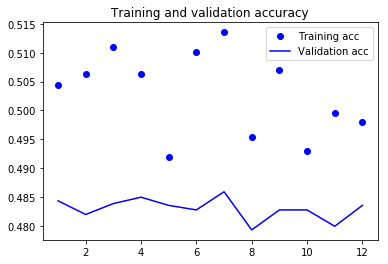

In [14]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()